## Initializing the notebook
These first few cells must be run first every time you are starting this program for the first time. The first cell imports a bunch of useful functions, and sets up some pretty plots. The second cell starts up a GUI that establishes communications with the lab equipment, sets up the experiment, and runs it.

**Note** This notebook is running a Python kernel, which is a dedicated computer process that just runs this stuff. At any time, you can interrupt an operation by going up to the "Kernel" menu and clicking Interrupt, or you can completely stop it and restart it by choosing Restart.

If you want to switch to a different program that uses any of the lab equipment that this program also uses, you will need to first restart the kernel, thus releasing ownership of those devices (there are other ways to do this as well, but this is the easiest).

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../../../pyscan-master/')

import pyscan as ps
import matplotlib.pyplot as plt
import numpy as np
import utility as ut
from time import sleep
from datetime import date, datetime
from pathlib import Path
from pulsesweep_gui import *
from pulsesweep_scripts import *
if 'devices' not in globals():
    devices = ps.ItemAttribute()
    sig = ps.ItemAttribute()
    sweep = {}

plt.rc('lines', lw=2)
plotfont = {'family': 'serif', 'size': 16}
plt.rc('font', **plotfont)
plt.rc('mathtext', fontset='cm')

wait = 0.05

controls, parameters = pulsesweep_gui(sig, devices, sweep)
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [2]:
controls

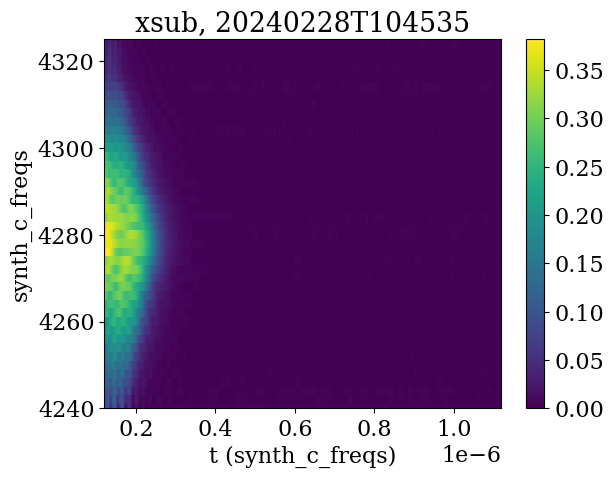

In [11]:
ps.live_plot2D(sweep['expt'], x_name='t', y_name=parameters['y_name'], data_name='xsub', transpose=1)

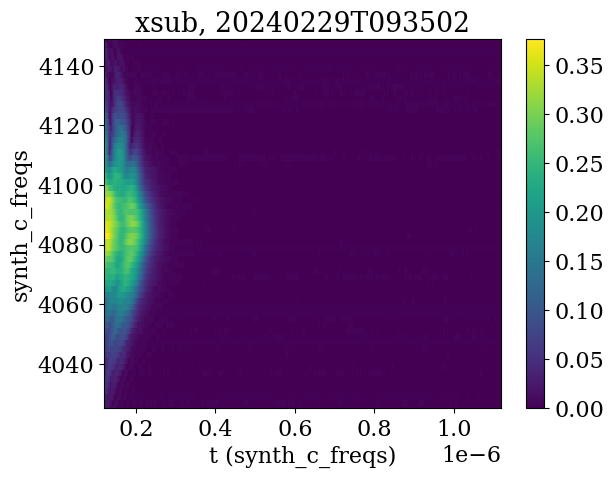

In [4]:
ps.live_plot2D(sweep['expt'], x_name='t', y_name=parameters['y_name'], data_name='xsub', transpose=1)

In [3]:
devices.ls335.get_temp()

2.989

array([[4.08912452e+03, 7.80020537e-01],
       [1.10939431e+00, 2.42855077e-02]])

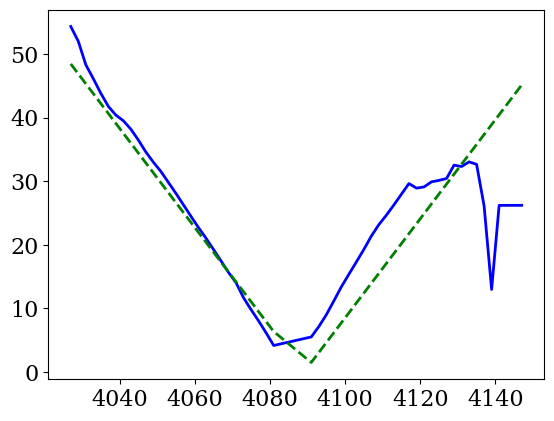

In [5]:
def absfit(x, x0, m):
    return np.abs(m*(x-x0))
fns = np.where(sweep['expt'].ffdetx!=0)[0]
fdat = np.array([np.array(sweep['expt'].synth_c_freqs)[fns], np.abs(sweep['expt'].ffdetx[fns]/1e6)]) #To slice this array: [:,:20]
ut.plot_func_fit(absfit, fdat, [np.mean(fdat[0]), np.mean(fdat[1])])

## Measure and Save
Run this set of cells to set up, measure, and save a pulsed frequency sweep. It will plot as a colormap, with yellow corresponding to high voltages and blue corresponding to low voltages. Running it this way will automatically save the data to the `backup` folder in the directory that holds this notebook.

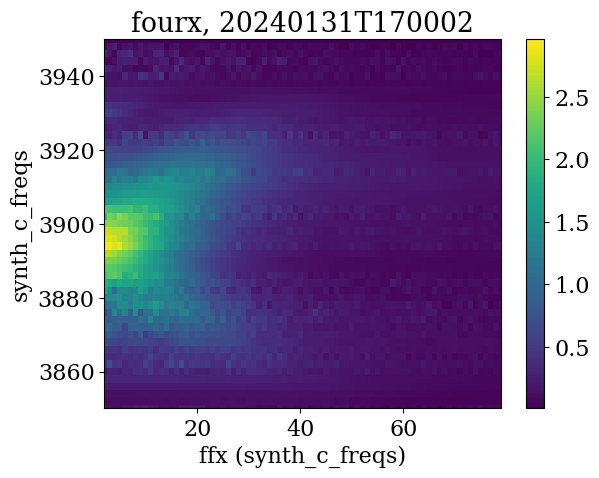

In [28]:
sweep['expt'].fourx = sweep['expt'].fourier[:, 3, 2:80]
sweep['expt'].ffx = sweep['expt'].ffreqs[:, 2:80]/1e6
ps.plot2D(sweep['expt'], x_name='ffx', y_name='synth_c_freqs', data_name='fourx', transpose=1)

In [7]:
dfs = []
fs = []
mult = -np.sign(np.diff(expt.synth_c_freqs)[0])
for n in range(len(expt.ffx)):
# for n in range(17, 50):
    try:
        dfs += [mult*ut.lor_fit(np.array([expt.ffx[n], -expt.fourx[n]]))[0][-1]]
        fs += [expt.synth_c_freqs[n]]
    except:
        if mult<0:
            mult = 1
ffit=np.polyfit(fs,dfs,1)
cfreq = -ffit[1]/ffit[0]
cfreq

NameError: name 'expt' is not defined

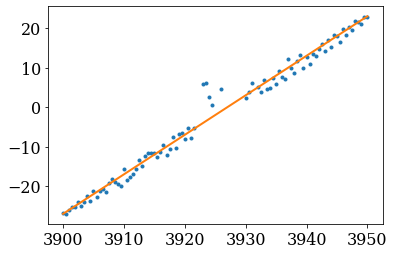

In [13]:
plt.plot(fs, dfs, '.', expt.synth_c_freqs, expt.synth_c_freqs-cfreq, '-')

In [94]:
test = [devices.scope.read_vxy() for n in range(10)]

In [95]:
from spinecho_scripts import *
[fourier_signal(t, 0) for t in test];

In [96]:
np.mean([t.fourier[1] for t in test], axis=0)

array([5.8156    , 4.05468655, 3.96511357, ..., 0.18001526, 0.17774546,
       0.186     ])

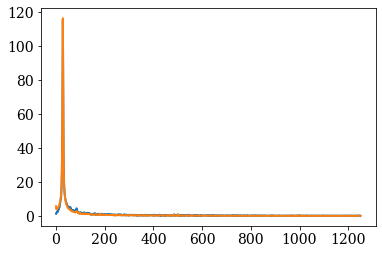

In [97]:
plt.plot(test[0].ffreqs/1e6, test[0].fourier[1], test[0].ffreqs/1e6, np.mean([t.fourier[1] for t in test], axis=0))

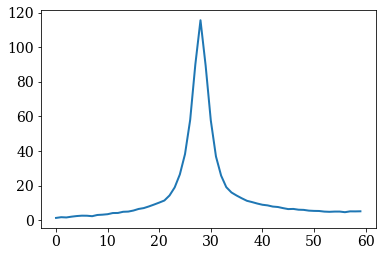

In [98]:
plt.plot(test[0].ffreqs[:60]/1e6, test[0].fourier[1][:60])

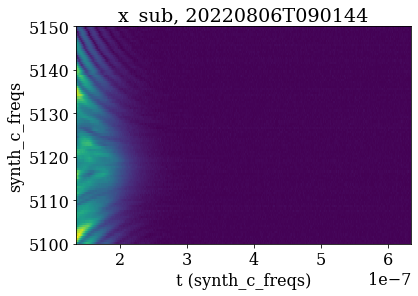

In [13]:
ps.live_plot2D(expt, x_name='t', y_name='synth_c_freqs', data_name='x_sub', transpose=1)

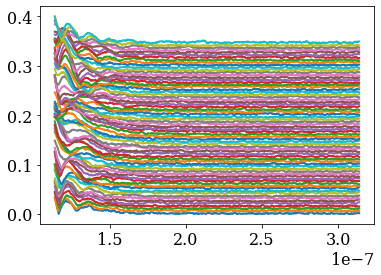

In [22]:
[plt.plot(expt.t[:1000], sig[:1000]+.005*n) for n, sig in enumerate(expt.x_sub[150:220])];

### Analyzing the data
You can now play around with and possibly even fit the data. Note that you can access the underlying data in other ways than just the colormap:
* If you wanted to look at the second trace from the oscilloscope, you could run `plt.plot(expt.t, expt.x_sub[1]);`
* If you wanted to look at all the data at $1.5\times10^{-7}$ s, and you found that that time corresponded to the 147th data point in the time series, you could run `plt.plot(expt.synth_c_freqs, expt.x_sub[:, 146]);`.
    * Note that you could find which data point it was using the following code: `np.abs(expt.t-1.5e-7).argmin()`
* If you wanted to fit the first trace to an exponential decay and see the results, you could run `ut.plot_exp_fit_norange(np.array([expt.t, expt.x_sub[1]]), expt.synth_c_freqs[1], 1)`. Don't forget that you can find out more about a function by running `?ut.plot_exp_fit_norange`.

In [5]:
nt = np.abs(sweep['expt'].t-1e-7).argmin()
nt
sweep['expt'].synth_c_freqs[sweep['expt'].xsub[:, nt].argmax()]

3466.0

In [4]:
plt.plot(sweep['expt'].synth_c_freqs, sweep['expt'].xsub[:, nt]);

AttributeError: 'Sweep' object has no attribute 'synth_c_freqs'

[array([-2.06077962e-02, -3.06446797e-01, -6.12177458e+01,  3.90405959e+03]),
 63.77333143833448]

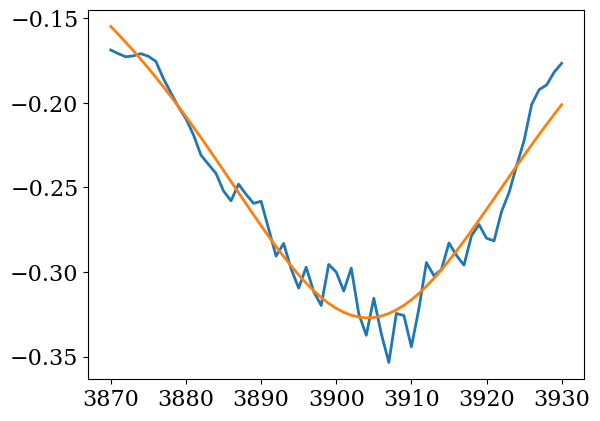

In [9]:
ut.plot_lor_fit(np.array([sweep['expt'].synth_c_freqs, -sweep['expt'].xsub[:, nt]]), full=1)

[array([-4.56598289e-03, -5.16943464e-02, -2.11617133e+01,  4.08209433e+03]),
 192.8999916387598]

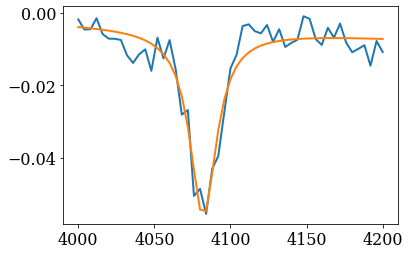

In [11]:
ut.plot_lor_fit(np.array([sweep['expt'].synth_c_freqs, -sweep['expt'].xsub[:, nt]]), full=1)

[array([ 1.93259934e-02, -1.56370410e-01,  9.09928019e+01,  4.90362147e+03]),
 53.89021295340594]

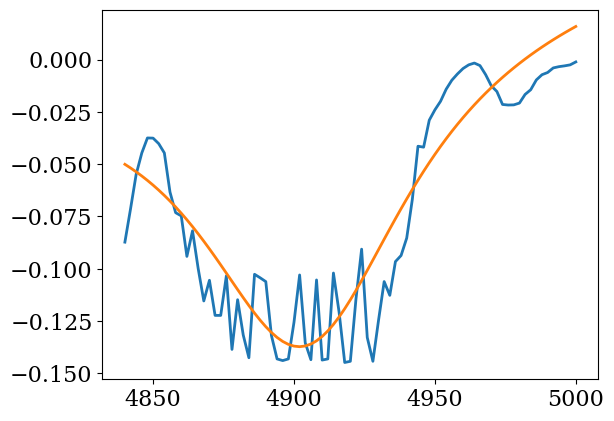

In [43]:
ut.plot_lor_fit(np.array([sweep['expt'].synth_c_freqs[70:], -sweep['expt'].xsub[:, nt][70:]]), full=1)

In [14]:
n = np.abs(expt.synth_c_freqs-3928).argmin()
n

0

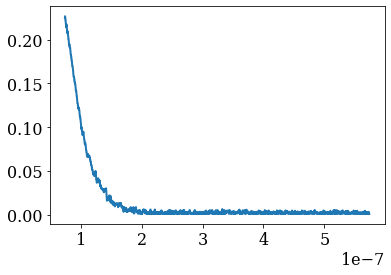

In [41]:
plt.plot(expt.t, expt.x_sub[n]);

array([2.20938892e-03, 4.78742505e+00, 2.60981922e-08, 3.22056283e+02])

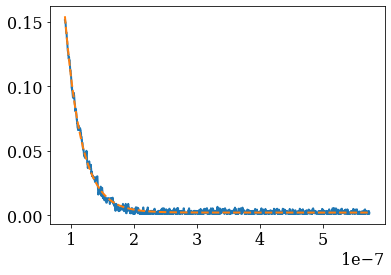

In [48]:
ut.plot_exp_fit(np.array([expt.t, expt.x_sub[n]]), expt.synth_c_freqs[n]*1e6, 0.9e-7, 6e-7)

In [105]:
devices.synth.c_freqs = 4375

In [68]:
devices.synth.c2_power = 0

In [69]:
devices.fpga.block = 0

In [48]:
devices.fpga.pulse_block = 300

In [35]:
devices.synth.c2_phase = 180

In [2]:
947/278

3.406474820143885

## Taking Q data

In [12]:
devices.scope.read_screen();

In [60]:
times = []
Qs = []
start = datetime.now().timestamp()
freq = devices.synth.c_freqs
sltime = devices.fpga.period*2e-9*devices.scope.average
reps = 10

def read_Q():
    time = datetime.now().timestamp()
    dt = (time-start)/60
    d = devices.scope.read_vxy(sltime=sltime, reps=reps)
    fit = ut.exp_fit_norange_noback(np.array([d.time-d.time[0], d.x_sub]), freq, 1)[0]
    Q = fit[-1]
    A = fit[0]
    times.append(time)
    Qs.append(Q)
#     save_temp(times, temps)
    
#     return [[time, time], [temp, setpoint]]
#     return dt, Q
    return dt, [Q, A]

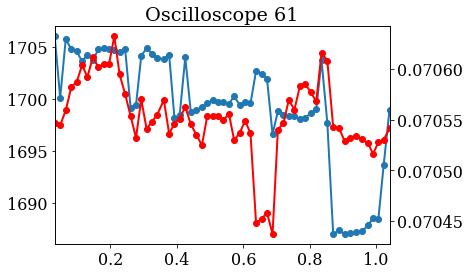

In [59]:
ps.oscilloscope(read_Q, np.inf, 0.1, numy=2)

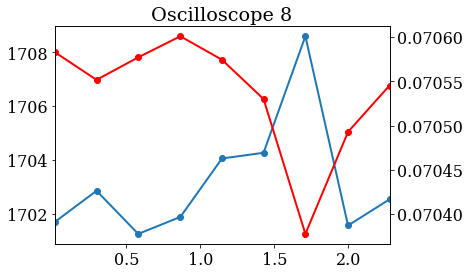

In [61]:
ps.oscilloscope(read_Q, np.inf, 0.1, numy=2)

In [143]:
devices.fpga.block = 1

# Field Sweep

In [28]:
def get_field(n):
    print(n)
    sleep(5)

def measure_fs(expt):
    runinfo = expt.runinfo
    devices = expt.devices

#     d = ps.ItemAttribute()
    
    if 'sltime' in runinfo.keys():
        sltime = runinfo.sltime
    else:
        sltime = runinfo.parameters['period']/1e9*2*runinfo.parameters['ave']
    if 'reps' in runinfo.keys():
        reps = runinfo.reps
    else:
        reps = 1
    
    sleep(sltime)
    d = devices.scope.read_vxy(sltime=sltime, reps=reps)
    expt.t = d.time
    d.fit, d.err = ut.exp_fit_norange_noback(np.array([d.time-d.time[0], d.xsub]), parameters['freq_start'], 1)[:2]
    d.Q = d.fit[-1]
    d.A = d.fit[0]
    
    return d

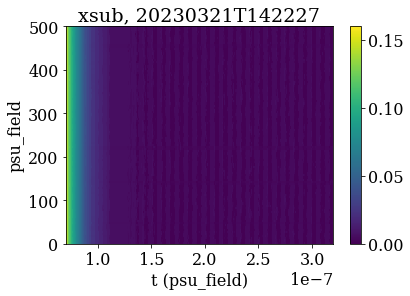

In [29]:
# 2D data
runinfo = ps.RunInfo()
runinfo.loop0 = ps.PropertyScan({'psu': ps.drange(0, 5, 500)}, prop='field', dt=wait)

runinfo.measure_function = measure_fs
devices.scope.read_scope()

runinfo.parameters = parameters
runinfo.reps = 20
# runinfo.sltime = .02*2*runinfo.average

runinfo.wait_time = 0.1 # devices.fpga.period*runinfo.average/1e9*1.1

expt = ps.Sweep(runinfo, devices, parameters['outfile']+'BSweep')
expt.start_thread()

ps.live_plot2D(expt, x_name='t', y_name='psu_field', data_name='xsub', transpose=1)

KeyboardInterrupt: 

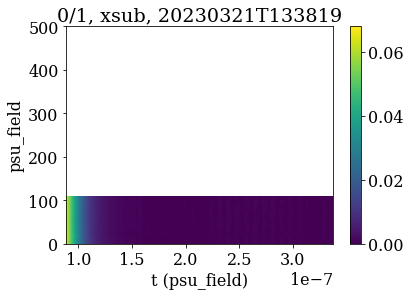

In [26]:
ps.live_plot2D(expt, x_name='t', y_name='psu_field', data_name='xsub', transpose=1)

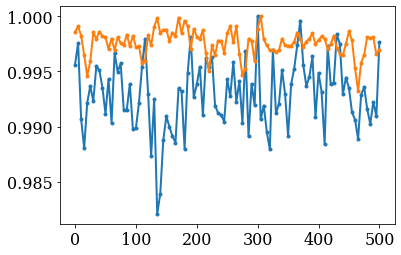

In [119]:
plt.plot(expt.psu_field, expt.v1famp/expt.v1famp.max(), '.-', expt.psu_field, expt.Q/expt.Q.max(), '.-')

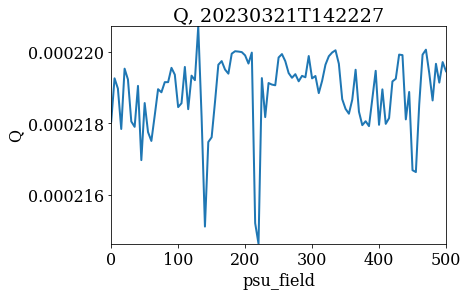

In [30]:
ps.live_plot1D(expt, x_name='psu_field', data_name='Q')

In [31]:
devices.psu.field = 0

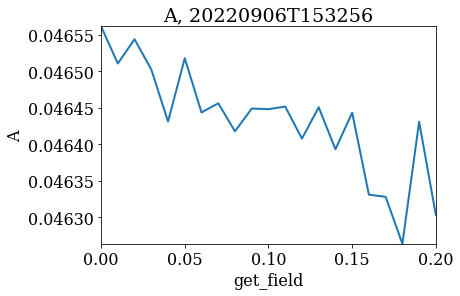

In [20]:
ps.live_plot1D(expt, x_name='get_field', data_name='A')

## Stopping the sweep
When you are done with your experiments, you should turn the output off, by running the following cell. You should also turn off the power supply, if it is on.

In [32]:
devices.synth.power_off()